In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
train_loader, valid_loader, test_loader = mnist(valid=10000, batch_size=64)

100.1%

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


113.5%

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw


100.4%

Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


180.4%

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw
Processing...
Done!


In [4]:
rho = 0.05
num_epochs = 30

train_log = []
test_log = []

In [5]:
# Conv + FC

class Encoder(nn.Module):
    def __init__(self, latent_size=64):
        super(Encoder, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.bn3 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 4 * 4, latent_size)
    
    def forward(self, x):
        # batch_size x 1 x 28 x 28
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        # batch_size x 8 x 12 x 12
        x = self.bn2(F.relu(self.conv2(x)))
        # batch_size x 16 x 10 x 10
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        # batch_size x 32 x 4 x 4
        x = x.view(-1, 32 * 4 * 4)
        # batch_size x 512
        x = F.sigmoid(self.fc1(x))
        # batch_size x latent_size
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=64):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 32 * 4 * 4)
        self.tconv1 = nn.ConvTranspose2d(32, 16, 5, 2)
        self.bn1 = nn.BatchNorm2d(16)
        self.tconv2 = nn.ConvTranspose2d(16, 8, 5, 2)
        self.bn2 = nn.BatchNorm2d(8)
        self.tconv3 = nn.ConvTranspose2d(8, 1, 4)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        # batch_size x latent_size
        x = x.view(-1, 32, 4, 4)
        # batch_size x 32 x 4 x 4
        x = self.bn1(F.relu(self.tconv1(x)))
        # batch_size x 16 x 11 x 11
        x = self.bn2(F.relu(self.tconv2(x)))
        # batch_size x 8 x 25 x 25
        x = F.tanh(self.tconv3(x))
        # batch_size x 3 x 28 x 28
        return x

In [6]:
class Net(nn.Module):
    def __init__(self, latent_size=64, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None

        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
        
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = -p * log(q) - (1 - p) * log(1- q)
        """
        dkl = - rho * torch.log(self.data_rho) - (1 - rho) * torch.log(1 - self.data_rho)

        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss

    def loss(self, x, target, **kwargs):
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss    

In [7]:
model = Net()

In [8]:
def train(epoch, model, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        model.optim.zero_grad()
        data = data.to(device)
        output = model(data)
        rho_loss = model.rho_loss(rho)
        loss = model.loss(output, data) + rho_loss
        loss.backward()
        model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            train_loss = '{:.6f}'.format(model._loss.item())
            print(line + train_loss)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        train_loss = '{:.6f}'.format(model._loss.item())
        if log:
            log.append((models._loss, models._rho_loss))
        print(line + train_loss)

In [9]:
avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'Rho loss: {:.4f}'.format(p)
line = lambda l, p: avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(model, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = 0
    rho_loss = 0
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = model(data)
            test_loss += model.loss(output, data, size_average=False).item() # sum up batch loss
            rho_loss += model.rho_loss(rho, size_average=False).item()
    
    test_loss /= (test_size * 784)
    rho_loss /= (test_size * model.latent_size)
    if log:
        log.append((test_loss, rho_loss))
    
    lines = '\n'.join([line(test_loss, rho_loss)]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [10]:
for epoch in range(1, num_epochs + 1):
    model = model.to(device)
    model.train()
    train(epoch, model, train_log)
    model.eval()
    test(model, valid_loader, test_log)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train Epoch: 1 [0/50000 (0%)]	Loss 1.430324
Train Epoch: 1 [12800/50000 (26%)]	Loss 0.739544
Train Epoch: 1 [25600/50000 (51%)]	Loss 0.640536
Train Epoch: 1 [38400/50000 (77%)]	Loss 0.530322
Train Epoch: 1 [12512/50000 (100%)]	Loss 0.510281


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set:
Loss: 0.4976	Rho loss: 0.0031

Train Epoch: 2 [0/50000 (0%)]	Loss 0.499910
Train Epoch: 2 [12800/50000 (26%)]	Loss 0.465187
Train Epoch: 2 [25600/50000 (51%)]	Loss 0.469186
Train Epoch: 2 [38400/50000 (77%)]	Loss 0.453092
Train Epoch: 2 [12512/50000 (100%)]	Loss 0.446524
Test set:
Loss: 0.4293	Rho loss: 0.0031

Train Epoch: 3 [0/50000 (0%)]	Loss 0.448261
Train Epoch: 3 [12800/50000 (26%)]	Loss 0.394747
Train Epoch: 3 [25600/50000 (51%)]	Loss 0.437019
Train Epoch: 3 [38400/50000 (77%)]	Loss 0.380925
Train Epoch: 3 [12512/50000 (100%)]	Loss 0.380058
Test set:
Loss: 0.4016	Rho loss: 0.0031

Train Epoch: 4 [0/50000 (0%)]	Loss 0.448542
Train Epoch: 4 [12800/50000 (26%)]	Loss 0.382581
Train Epoch: 4 [25600/50000 (51%)]	Loss 0.417350
Train Epoch: 4 [38400/50000 (77%)]	Loss 0.368233
Train Epoch: 4 [12512/50000 (100%)]	Loss 0.373744
Test set:
Loss: 0.3874	Rho loss: 0.0031

Train Epoch: 5 [0/50000 (0%)]	Loss 0.397752
Train Epoch: 5 [12800/50000 (26%)]	Loss 0.415168
Train Epoch: 5 [2560

Train Epoch: 30 [12512/50000 (100%)]	Loss 0.353055
Test set:
Loss: 0.3441	Rho loss: 0.0031



In [11]:
data, _ = next(iter(test_loader))
output = model(data.to(device))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


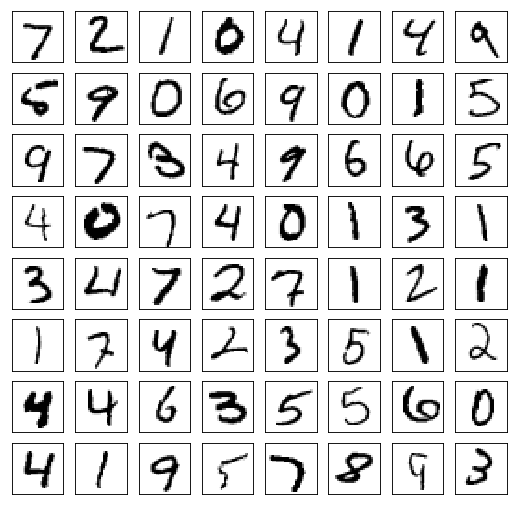

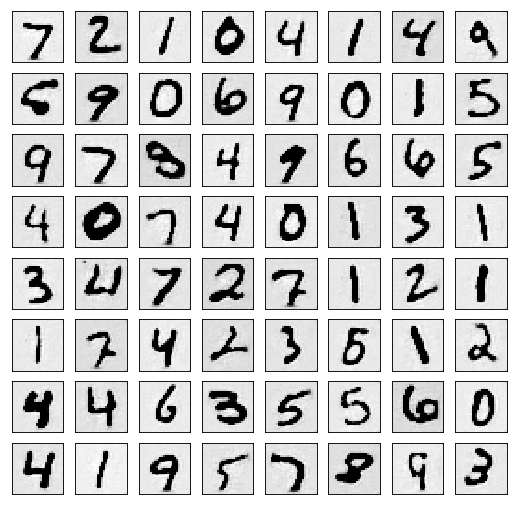

In [12]:
plot_mnist(data.data.numpy(), (8, 8))
plot_mnist(output.data.cpu().numpy(), (8, 8))

In [13]:
img, _ = next(iter(test_loader))
img = nn.Parameter(img)
img_opt = optim.Adam(params=[img], lr=1e-4)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Loss: 0.0099000204


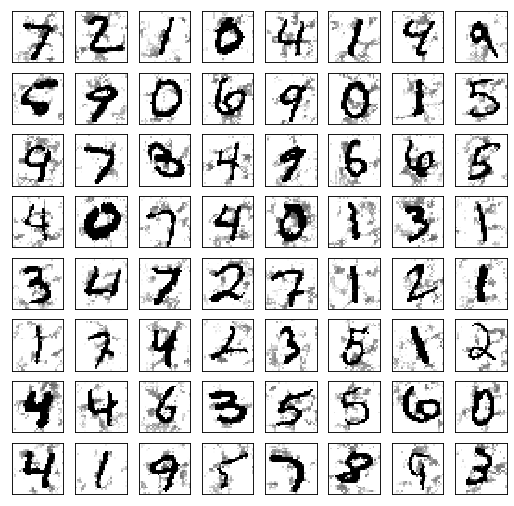

Loss: 0.0048340694


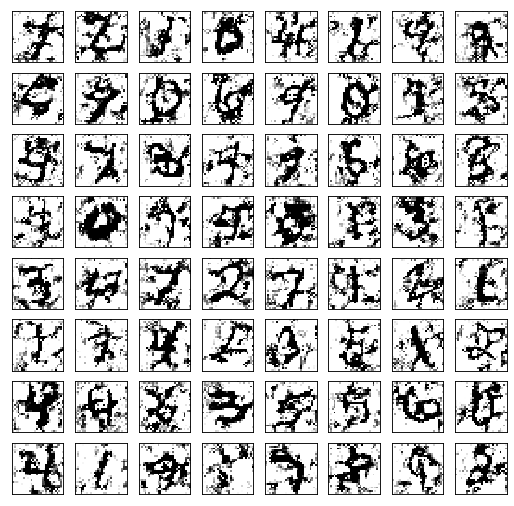

Loss: 0.0022601220


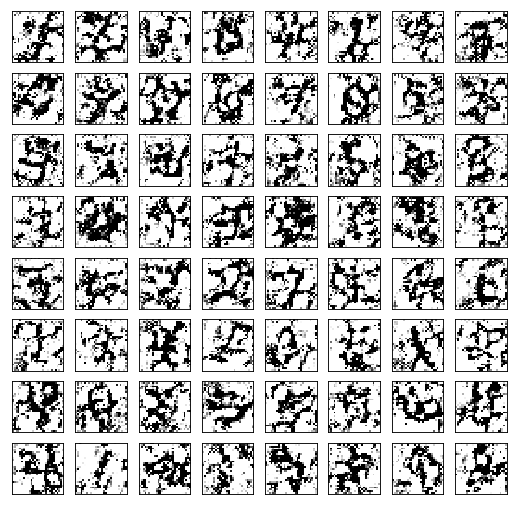

Loss: 0.0011118966


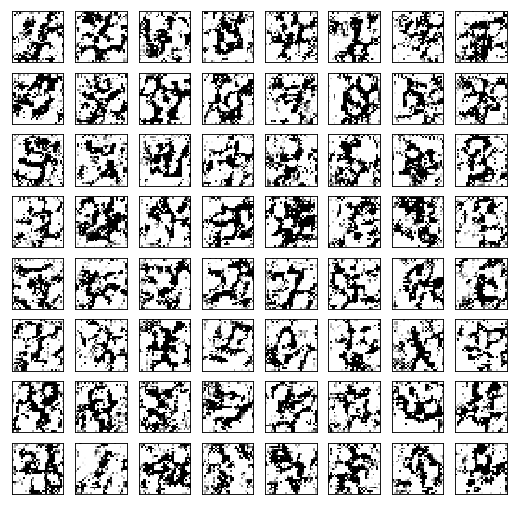

Loss: 0.0005906861


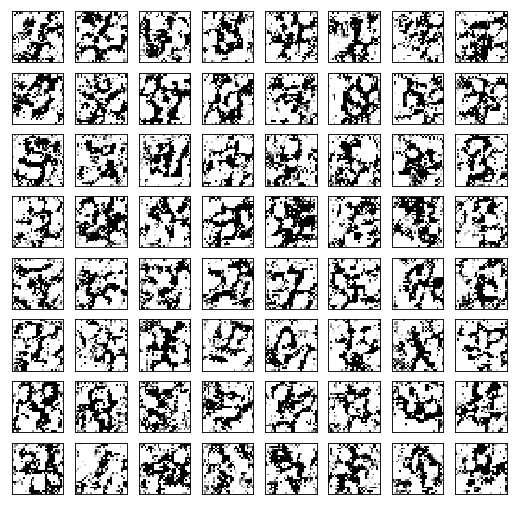

Loss: 0.0003445604


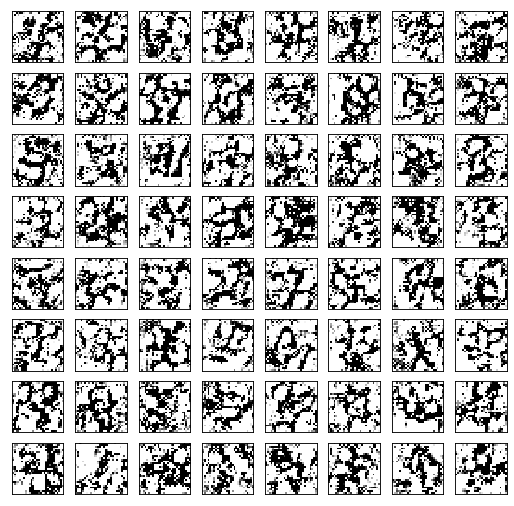

Loss: 0.0002192258


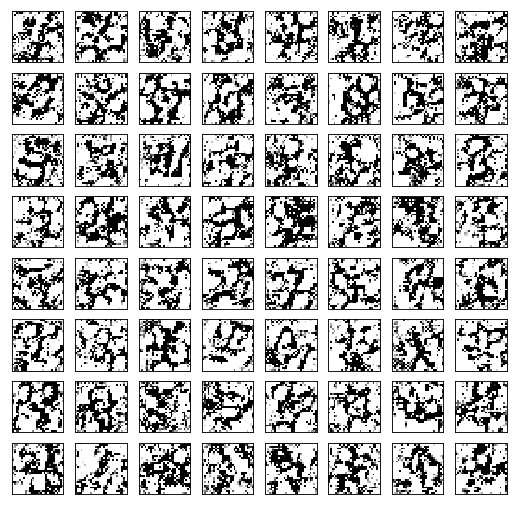

Loss: 0.0001482254


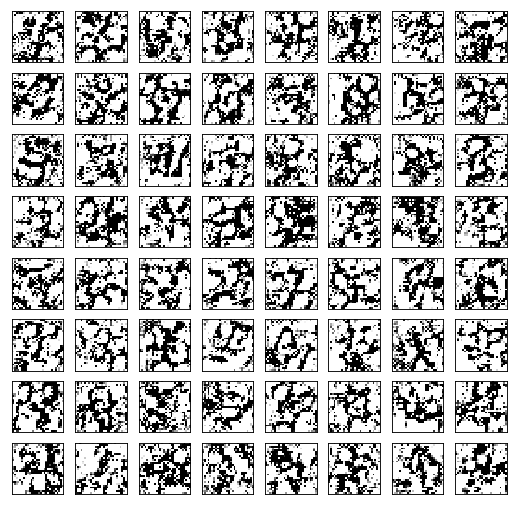

Loss: 0.0001056633


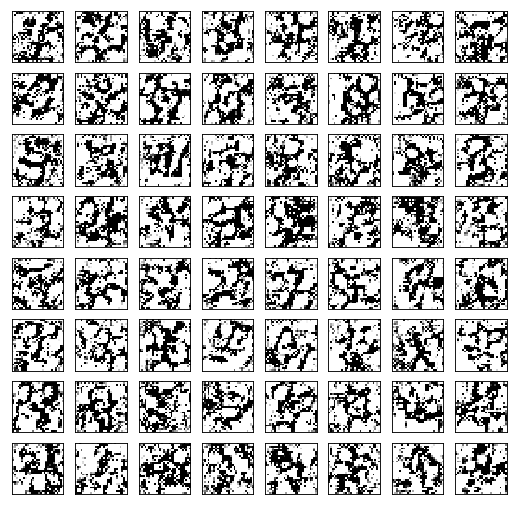

Loss: 0.0000792358


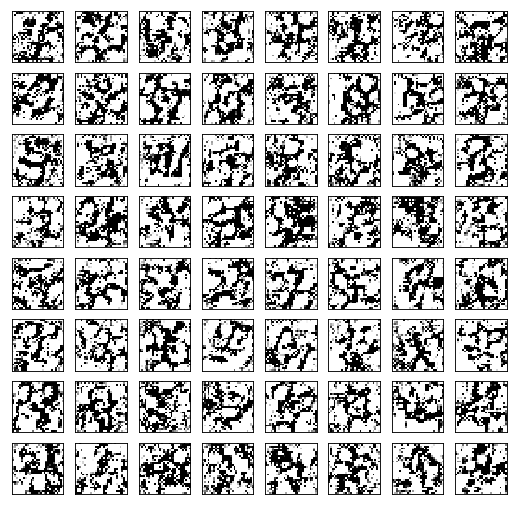

In [14]:
# image optimization based on FC layer activations
for i in range(1, 100001):
    img_opt.zero_grad()
    encoded = model.E(img.to(device))
    img_loss = F.mse_loss(encoded, torch.eye(64).to(device))
    img_loss.backward()
    img_opt.step()
    
    if i % 10000 == 0:
        print(f'Loss: {img_loss.item():.10f}')
        plot_mnist(img.clamp(0, 1).data.numpy(), (8, 8))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


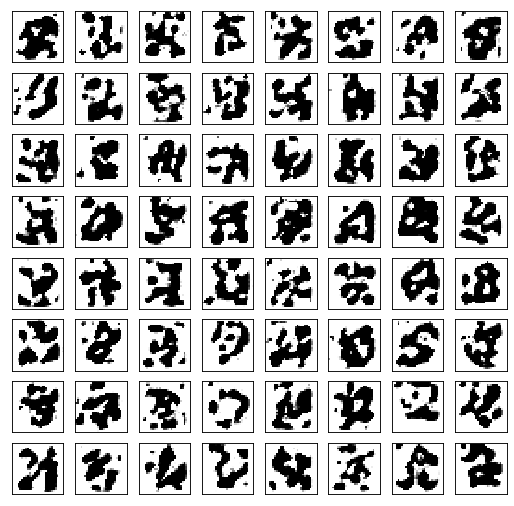

In [15]:
# decoding the encoded optimized images
decoded = model.decode(encoded)
plot_mnist(decoded.data.cpu().clamp(0, 1).numpy(), (8, 8))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


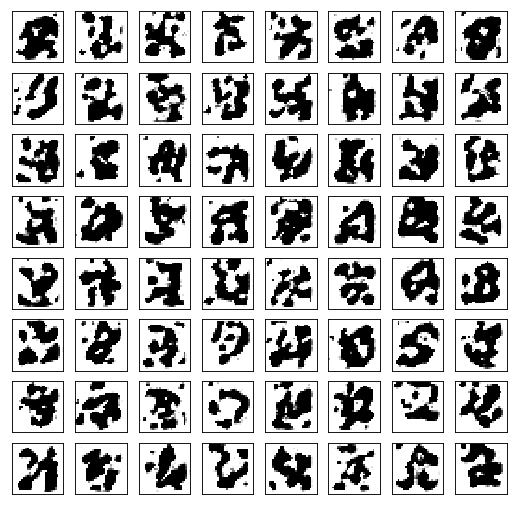

In [16]:
# decoding the 64x64 identity matrix
decoded_oh = model.decode(torch.eye(64).to(device))
plot_mnist(decoded_oh.data.cpu().clamp(0, 1).numpy(), (8, 8))

In [17]:
# purely convolutional autoencoder

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3)
    
    def forward(self, x):
        # batch_size x 1 x 28 x 28
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        # batch_size x 8 x 12 x 12
        x = self.bn2(F.relu(self.conv2(x)))
        # batch_size x 16 x 10 x 10
        x = self.pool(F.sigmoid(self.conv3(x)))
        # batch_size x 32 x 4 x 4
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tconv1 = nn.ConvTranspose2d(32, 16, 5, 2)
        self.bn1 = nn.BatchNorm2d(16)
        self.tconv2 = nn.ConvTranspose2d(16, 8, 5, 2)
        self.bn2 = nn.BatchNorm2d(8)
        self.tconv3 = nn.ConvTranspose2d(8, 1, 4)
    
    def forward(self, x):
        # batch_size x 32 x 4 x 4
        x = self.bn1(F.relu(self.tconv1(x)))
        # batch_size x 16 x 11 x 11
        x = self.bn2(F.relu(self.tconv2(x)))
        # batch_size x 8 x 25 x 25
        x = F.tanh(self.tconv3(x))
        # batch_size x 3 x 28 x 28
        return x

In [18]:
class Net(nn.Module):
    def __init__(self, latent_size=64, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder()
        self.D = Decoder()
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None

        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def conv(self, x):
        x = self.E.pool(self.E.bn1(F.relu(self.E.conv1(x))))
        x = self.E.bn2(F.relu(self.E.conv2(x)))
        x = self.E.pool(F.sigmoid(self.E.conv3(x)))
        return x
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
        
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = -p * log(q) - (1 - p) * log(1- q)
        """
        dkl = - rho * torch.log(self.data_rho) - (1 - rho) * torch.log(1 - self.data_rho)

        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss

    def loss(self, x, target, **kwargs):
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss  

In [19]:
model2 = Net()

In [20]:
for epoch in range(1, num_epochs + 1):
    model2 = model2.to(device)
    model2.train()
    train(epoch, model2)
    model2.eval()
    test(model2, valid_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train Epoch: 1 [0/50000 (0%)]	Loss 1.373104
Train Epoch: 1 [12800/50000 (26%)]	Loss 0.491124
Train Epoch: 1 [25600/50000 (51%)]	Loss 0.476290
Train Epoch: 1 [38400/50000 (77%)]	Loss 0.417175
Train Epoch: 1 [12512/50000 (100%)]	Loss 0.429482


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set:
Loss: 0.4207	Rho loss: 0.0649

Train Epoch: 2 [0/50000 (0%)]	Loss 0.407081
Train Epoch: 2 [12800/50000 (26%)]	Loss 0.406600
Train Epoch: 2 [25600/50000 (51%)]	Loss 0.393393
Train Epoch: 2 [38400/50000 (77%)]	Loss 0.415203
Train Epoch: 2 [12512/50000 (100%)]	Loss 0.410888
Test set:
Loss: 0.3900	Rho loss: 0.0315

Train Epoch: 3 [0/50000 (0%)]	Loss 0.390612
Train Epoch: 3 [12800/50000 (26%)]	Loss 0.354303
Train Epoch: 3 [25600/50000 (51%)]	Loss 0.378336
Train Epoch: 3 [38400/50000 (77%)]	Loss 0.381407
Train Epoch: 3 [12512/50000 (100%)]	Loss 0.333026
Test set:
Loss: 0.3717	Rho loss: 0.0258

Train Epoch: 4 [0/50000 (0%)]	Loss 0.384741
Train Epoch: 4 [12800/50000 (26%)]	Loss 0.389125
Train Epoch: 4 [25600/50000 (51%)]	Loss 0.373929
Train Epoch: 4 [38400/50000 (77%)]	Loss 0.354565
Train Epoch: 4 [12512/50000 (100%)]	Loss 0.386134
Test set:
Loss: 0.3611	Rho loss: 0.0251

Train Epoch: 5 [0/50000 (0%)]	Loss 0.356042
Train Epoch: 5 [12800/50000 (26%)]	Loss 0.399177
Train Epoch: 5 [2560

Train Epoch: 30 [12512/50000 (100%)]	Loss 0.309019
Test set:
Loss: 0.3327	Rho loss: 0.0250



In [21]:
img2, _ = next(iter(test_loader))
output2 = model2(img2.to(device))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


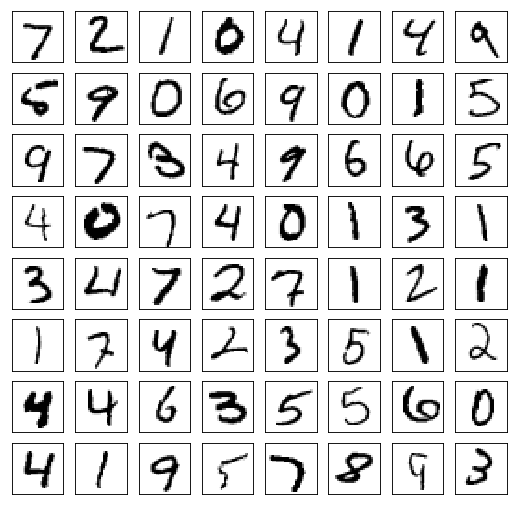

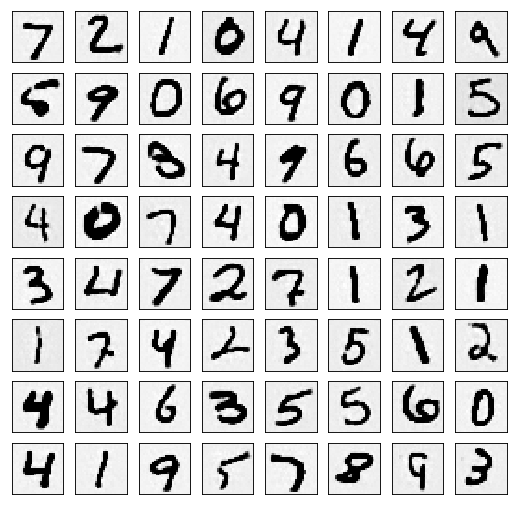

In [22]:
# plotting original images and those reconstructed by ConvAE
plot_mnist(img2.data.numpy(), (8, 8))
plot_mnist(output2.data.cpu().numpy(), (8, 8))

In [23]:
img_transform = transforms.Compose([
                transforms.Resize((16, 16)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
           ])
_, _, test_loader2 = mnist(valid=10000, batch_size=32, transform=img_transform)

In [24]:
img3, _ = next(iter(test_loader2))
img3 = nn.Parameter(img3)
img_opt3 = optim.Adam(params=[img3], lr=1e-4)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Loss: 0.0174892470


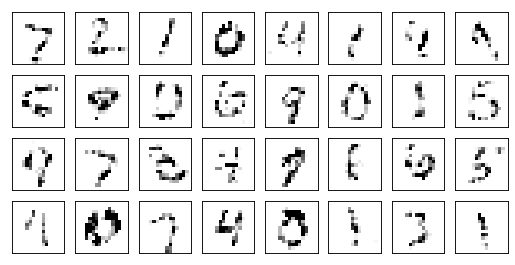

Loss: 0.0108302804


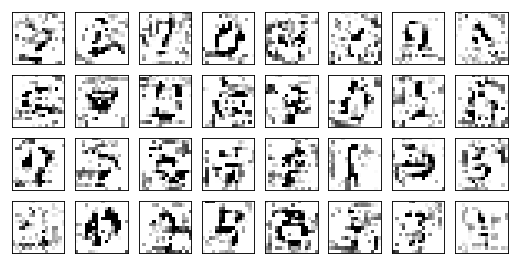

Loss: 0.0076058083


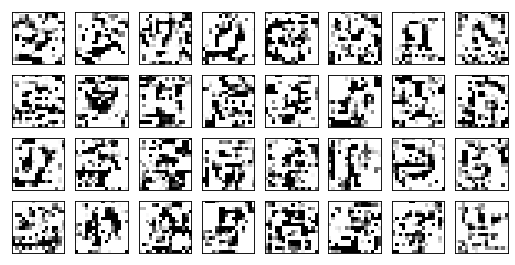

Loss: 0.0057452573


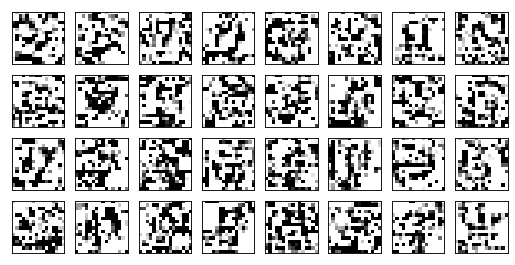

Loss: 0.0045291842


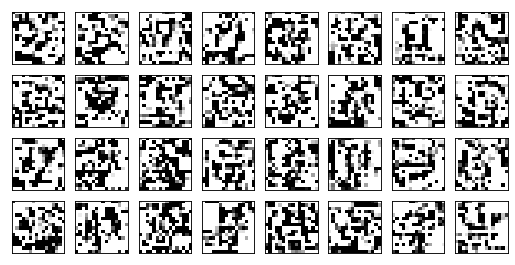

Loss: 0.0036778129


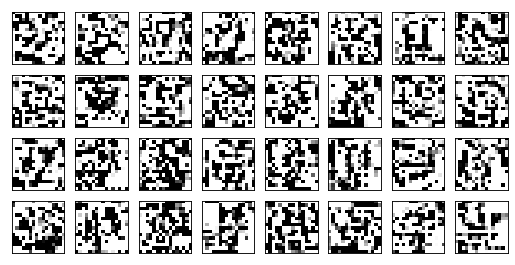

Loss: 0.0030360469


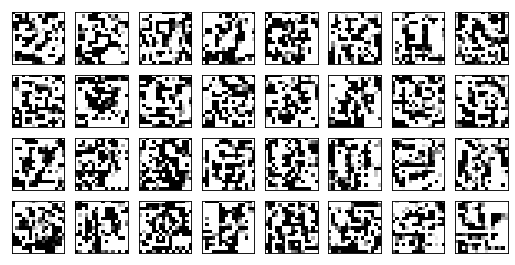

Loss: 0.0025517507


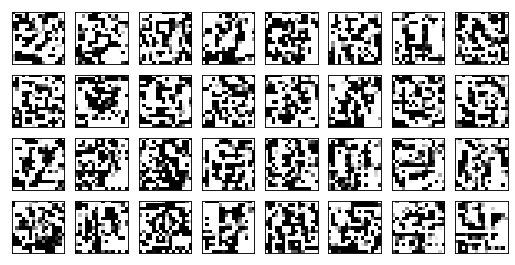

Loss: 0.0021730349


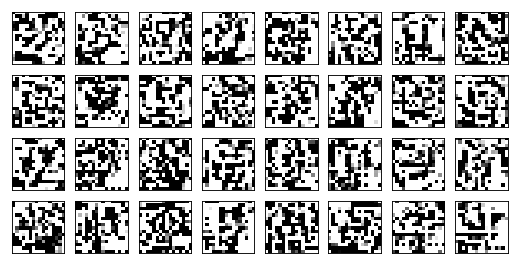

Loss: 0.0018688104


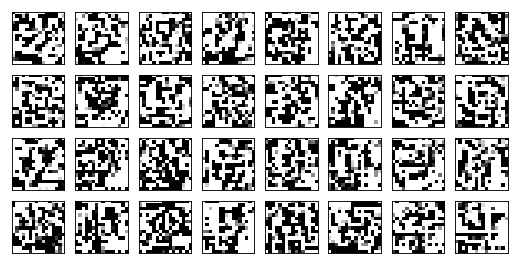

In [25]:
# image optimization based on convolutional layer activations
for i in range(1, 100001):
    img_opt3.zero_grad()
    encoded3 = model2.conv(img3.to(device))
    img_loss3 = F.mse_loss(encoded3.view(-1, 32), torch.eye(32).to(device))
    img_loss3.backward()
    img_opt3.step()
    
    if i % 10000 == 0:
        print(f'Loss: {img_loss3.item():.10f}')
        plot_mnist(img3.clamp(0, 1).data.numpy(), (4, 8))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


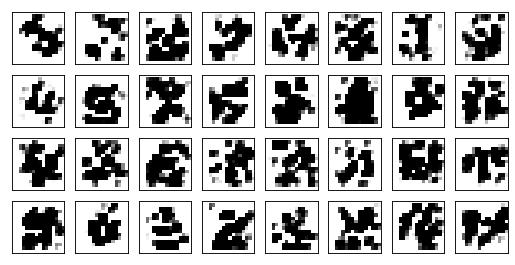

In [26]:
# decoding the encoded optimized images
decoded_conv = model2.decode(encoded3)
plot_mnist(decoded_conv.data.cpu().clamp(0, 1).numpy(), (4, 8))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


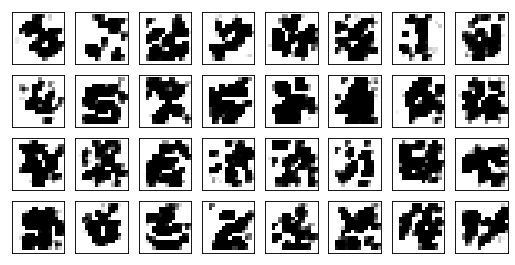

In [27]:
# decoding the 32x32 identity matrix
decoded_oh_conv = model2.decode(torch.eye(32).view(32, 32, 1, 1).to(device))
plot_mnist(decoded_oh_conv.data.cpu().clamp(0, 1).numpy(), (4, 8))

In [28]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(*size, padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [29]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [30]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*7*7, 10], dropout=dropout)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [31]:
models = {'model3': Net(True)}
train_log = {m: [] for m in models}
test_log = {m: [] for m in models}

In [32]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [33]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [34]:
for epoch in range(1, num_epochs + 1):
    for model in models.values():
        model = model.to(device)
        model.train()
    train(epoch, models, train_log)
    model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses model3: 2.263321
Train Epoch: 1 [12800/50000 (26%)]	Losses model3: 1.513985
Train Epoch: 1 [25600/50000 (51%)]	Losses model3: 1.081831
Train Epoch: 1 [38400/50000 (77%)]	Losses model3: 0.736885
Train Epoch: 1 [12512/50000 (100%)]	Losses model3: 0.806666


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set:
model3: Loss: 0.6072	Accuracy: 9187.0/10000 (92%)

Train Epoch: 2 [0/50000 (0%)]	Losses model3: 0.621785
Train Epoch: 2 [12800/50000 (26%)]	Losses model3: 0.490689
Train Epoch: 2 [25600/50000 (51%)]	Losses model3: 0.433181
Train Epoch: 2 [38400/50000 (77%)]	Losses model3: 0.429674
Train Epoch: 2 [12512/50000 (100%)]	Losses model3: 0.153303
Test set:
model3: Loss: 0.3045	Accuracy: 9450.0/10000 (94%)

Train Epoch: 3 [0/50000 (0%)]	Losses model3: 0.300275
Train Epoch: 3 [12800/50000 (26%)]	Losses model3: 0.267808
Train Epoch: 3 [25600/50000 (51%)]	Losses model3: 0.408814
Train Epoch: 3 [38400/50000 (77%)]	Losses model3: 0.194847
Train Epoch: 3 [12512/50000 (100%)]	Losses model3: 0.172272
Test set:
model3: Loss: 0.2097	Accuracy: 9591.0/10000 (96%)

Train Epoch: 4 [0/50000 (0%)]	Losses model3: 0.220308
Train Epoch: 4 [12800/50000 (26%)]	Losses model3: 0.148060
Train Epoch: 4 [25600/50000 (51%)]	Losses model3: 0.173314
Train Epoch: 4 [38400/50000 (77%)]	Losses model3: 0.147076
Trai

Train Epoch: 25 [12800/50000 (26%)]	Losses model3: 0.048237
Train Epoch: 25 [25600/50000 (51%)]	Losses model3: 0.025113
Train Epoch: 25 [38400/50000 (77%)]	Losses model3: 0.023843
Train Epoch: 25 [12512/50000 (100%)]	Losses model3: 0.006614
Test set:
model3: Loss: 0.0421	Accuracy: 9870.0/10000 (99%)

Train Epoch: 26 [0/50000 (0%)]	Losses model3: 0.016169
Train Epoch: 26 [12800/50000 (26%)]	Losses model3: 0.028080
Train Epoch: 26 [25600/50000 (51%)]	Losses model3: 0.016518
Train Epoch: 26 [38400/50000 (77%)]	Losses model3: 0.013356
Train Epoch: 26 [12512/50000 (100%)]	Losses model3: 0.015814
Test set:
model3: Loss: 0.0413	Accuracy: 9873.0/10000 (99%)

Train Epoch: 27 [0/50000 (0%)]	Losses model3: 0.037001
Train Epoch: 27 [12800/50000 (26%)]	Losses model3: 0.022498
Train Epoch: 27 [25600/50000 (51%)]	Losses model3: 0.022165
Train Epoch: 27 [38400/50000 (77%)]	Losses model3: 0.105540
Train Epoch: 27 [12512/50000 (100%)]	Losses model3: 0.040319
Test set:
model3: Loss: 0.0407	Accuracy: 9872

In [35]:
_, _, test_loader3 = mnist(valid=10000, batch_size=32)

In [36]:
img4, _ = next(iter(test_loader3))
img4 = nn.Parameter(img4)
img_opt4 = optim.Adam(params=[img4], lr=1e-4)

Loss: 0.1116513312


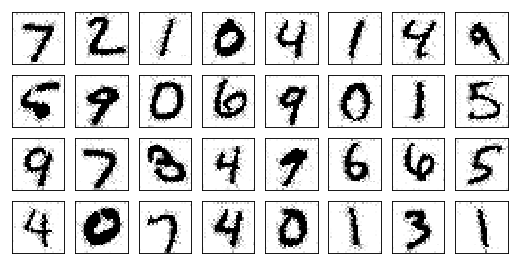

Loss: 0.0889503136


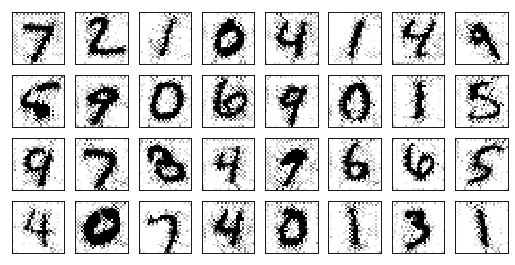

Loss: 0.0804225281


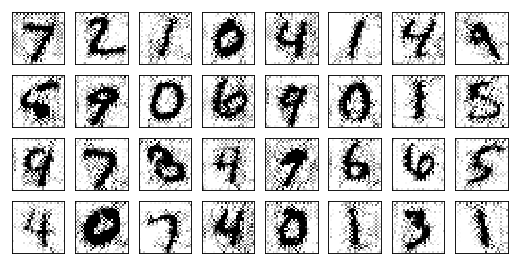

Loss: 0.0758032501


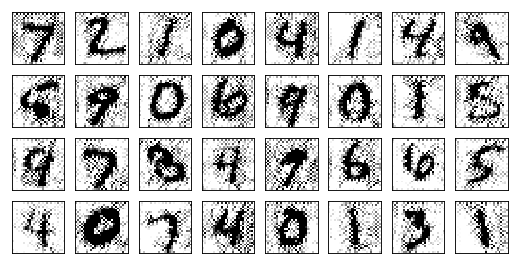

Loss: 0.0728548840


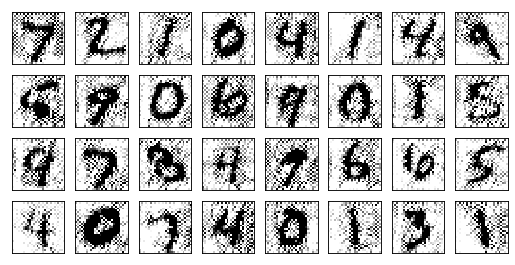

Loss: 0.0706937462


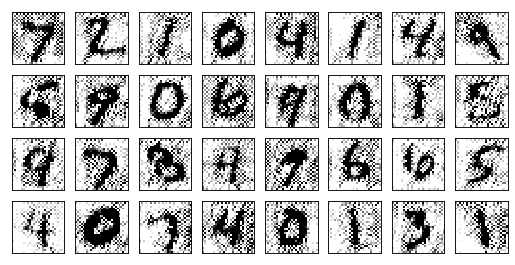

Loss: 0.0689072609


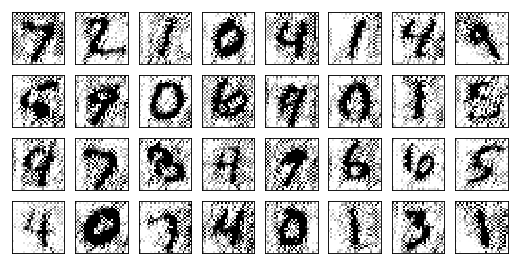

Loss: 0.0677506402


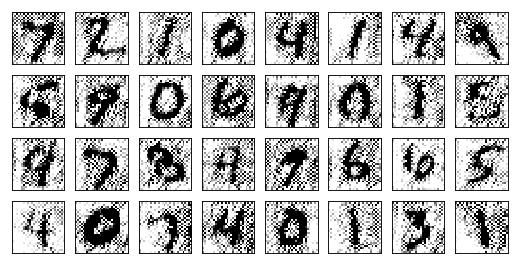

KeyboardInterrupt: 

In [37]:
# image optimization based on convolutional layer activations
for i in range(1, 100001):
    img_opt4.zero_grad()
    encoded4 = models['model3'].conv(img4.to(device))
    img_loss4 = F.mse_loss(encoded4.mean(2).mean(2), torch.eye(32).to(device))
    img_loss4.backward()
    img_opt4.step()
    
    if i % 10000 == 0:
        print(f'Loss: {img_loss4.item():.10f}')
        plot_mnist(img4.clamp(0, 1).data.numpy(), (4, 8))